In [383]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
plt.style.use('ggplot')
import pickle
import time

warnings.simplefilter(action="ignore", category=FutureWarning)

In [384]:
df = pd.read_csv("C:/Users/HP/Documents/DATASETS/Earthquake nepal/csv_building_structure22.csv")
df.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,1.200000e+11,12,1207,120703,1,1,9,288,9,9,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,1.200000e+11,12,1207,120703,1,1,15,364,9,9,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
2,1.200000e+11,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
3,1.200000e+11,12,1207,120703,1,1,20,312,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
4,1.200000e+11,12,1207,120703,1,1,30,308,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


In [385]:
df.shape

(387965, 31)

In [386]:
## Checking for duplicates
df.duplicated().sum()

78581

In [387]:
df = df.drop_duplicates(keep=False)

In [388]:
# checking to see the data types of the columns and to see if there are missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235399 entries, 0 to 387964
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             235399 non-null  float64
 1   district_id                             235399 non-null  int64  
 2   vdcmun_id                               235399 non-null  int64  
 3   ward_id                                 235399 non-null  int64  
 4   count_floors_pre_eq                     235399 non-null  int64  
 5   count_floors_post_eq                    235399 non-null  int64  
 6   age_building                            235399 non-null  int64  
 7   plinth_area_sq_ft                       235399 non-null  int64  
 8   height_ft_pre_eq                        235399 non-null  int64  
 9   height_ft_post_eq                       235399 non-null  int64  
 10  land_surface_condition                  2353

In [389]:
def downcast_dtypes(df):
    _start = df.memory_usage(deep=True).sum() / 1024 ** 2
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32" ]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    _end = df.memory_usage(deep=True).sum() / 1024 ** 2
    saved = (_start - _end) / _start * 100
    print(f"Saved {saved:.2f}%")
    return df   

In [390]:
df = downcast_dtypes(df)

Saved 20.78%


In [391]:
# getting further look into the missing values
df.isnull().sum()

building_id                               0
district_id                               0
vdcmun_id                                 0
ward_id                                   0
count_floors_pre_eq                       0
count_floors_post_eq                      0
age_building                              0
plinth_area_sq_ft                         0
height_ft_pre_eq                          0
height_ft_post_eq                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar

In [392]:
display(df.dtypes.value_counts())
df.dtypes

int16      20
object     10
float32     1
dtype: int64

building_id                               float32
district_id                                 int16
vdcmun_id                                   int16
ward_id                                     int16
count_floors_pre_eq                         int16
count_floors_post_eq                        int16
age_building                                int16
plinth_area_sq_ft                           int16
height_ft_pre_eq                            int16
height_ft_post_eq                           int16
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int16
has_superstructure_mud_mortar_stone         int16
has_superstructure_stone_flag               int16


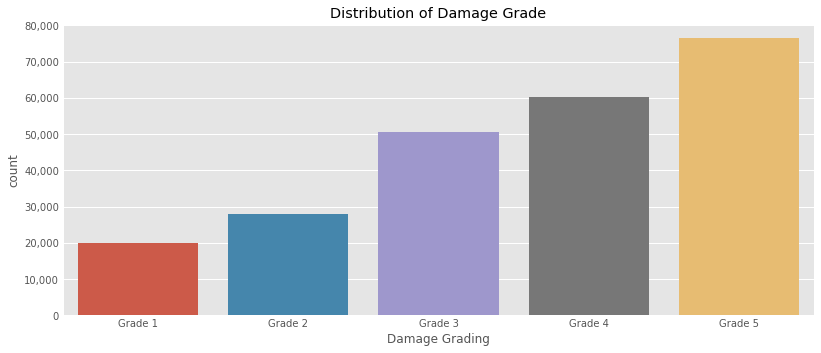

In [393]:
import matplotlib.ticker as mtick # Axis visuals
plt.figure(figsize=(12,5))
ax = sns.countplot(x='damage_grade', data=df, order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.title("Distribution of Damage Grade")
plt.xlabel("Damage Grading")
plt.show()

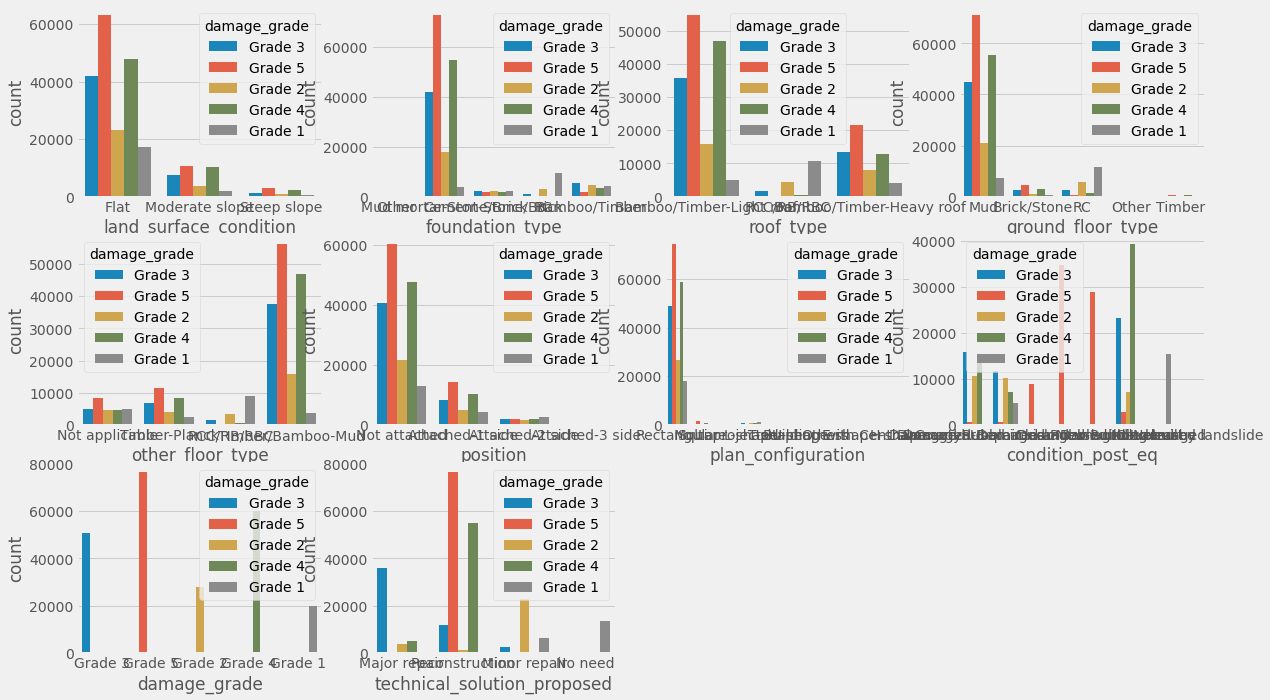

In [394]:
# Count plot on categorical columns
cat_cols = df.select_dtypes(include=np.object_).columns

def catPlot(cat_cols):
    plt.rcParams['font.size'] = 18
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(18,15))
    for i,txt in enumerate(cat_cols):
        ax = fig.add_subplot(4,4,i+1)
        sns.countplot(x=df[txt], ax=ax, hue=df['damage_grade'])
    plt.show()
catPlot(cat_cols)

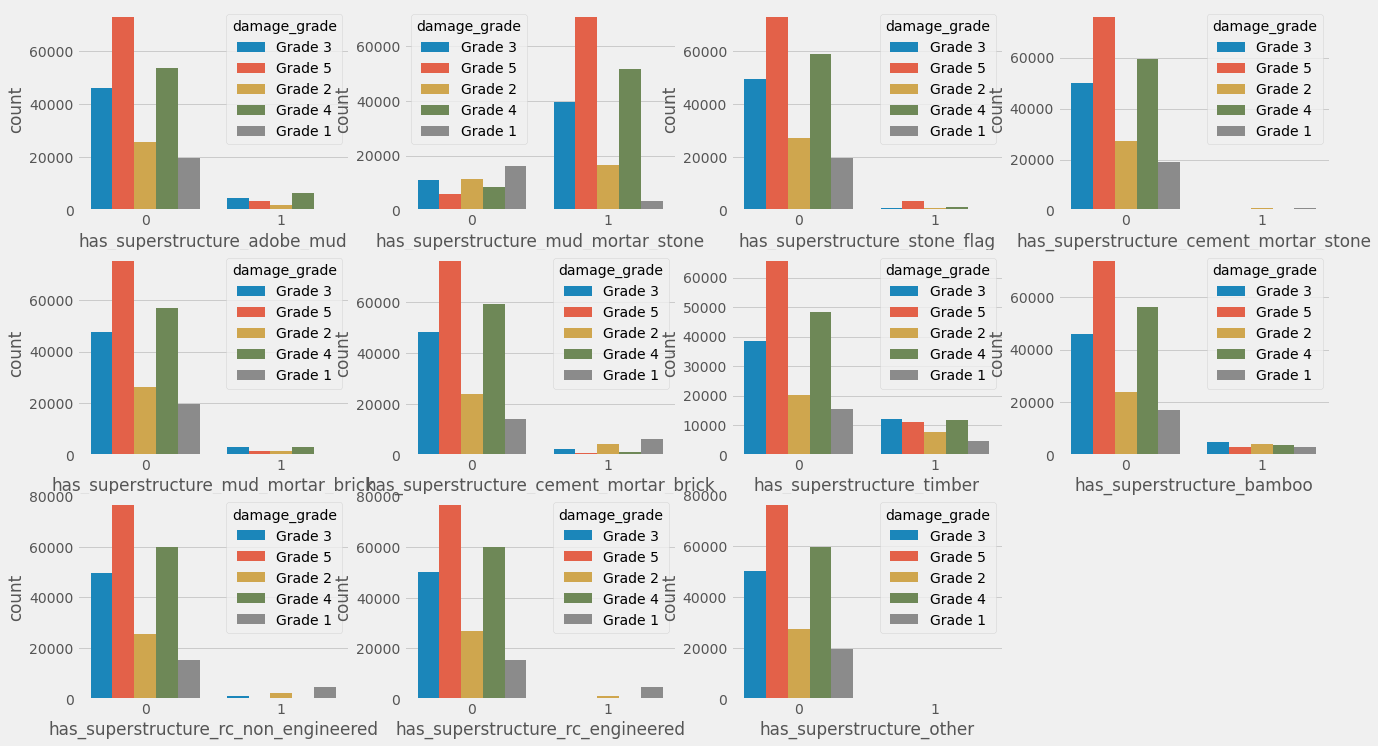

In [395]:
#Binary columns are selected using the column name having word 'has'
bin_cols = df.columns[df.columns.str.startswith('has')]

def countPlot(bin_cols):
    plt.rcParams['font.size'] = 18
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(20,37))
    for i,txt in enumerate(bin_cols):
        ax = fig.add_subplot(9,4,i+1)
        sns.countplot(x=df[txt], ax=ax, hue=df['damage_grade'])
    plt.show()
countPlot(bin_cols)

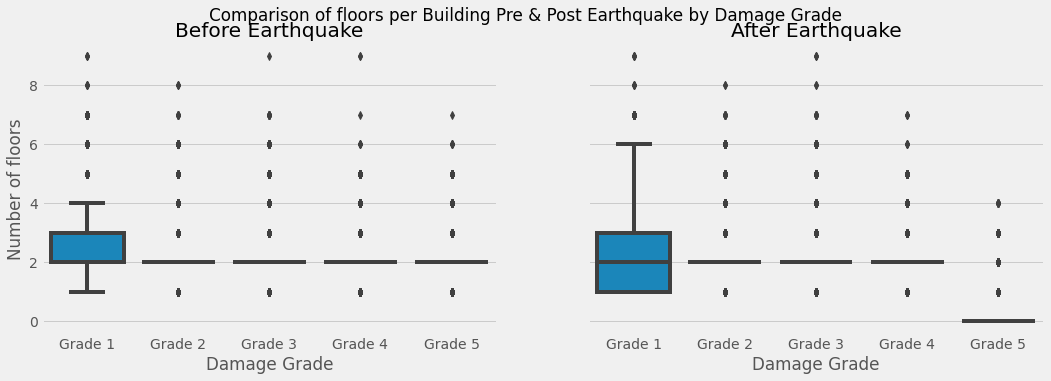

In [396]:
fig, ax = plt.subplots(1,2,figsize = (16,5), sharey='row')
fig.suptitle("Comparison of floors per Building Pre & Post Earthquake by Damage Grade")
ax[0].set_title("Before Earthquake")
ax[1].set_title("After Earthquake")
sns.boxplot(data = df, 
            x = "damage_grade", 
            y = "count_floors_pre_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[0])
sns.boxplot(data = df, 
            x = "damage_grade", 
            y = "count_floors_post_eq", 
            order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'],
            ax = ax[1])
plt.setp(ax[:], xlabel='Damage Grade')
plt.setp(ax[0], ylabel='Number of floors')
plt.setp(ax[1], ylabel=None)
plt.show()

In [397]:
df.dropna(inplace = True)

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235398 entries, 0 to 387964
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             235398 non-null  float32
 1   district_id                             235398 non-null  int16  
 2   vdcmun_id                               235398 non-null  int16  
 3   ward_id                                 235398 non-null  int16  
 4   count_floors_pre_eq                     235398 non-null  int16  
 5   count_floors_post_eq                    235398 non-null  int16  
 6   age_building                            235398 non-null  int16  
 7   plinth_area_sq_ft                       235398 non-null  int16  
 8   height_ft_pre_eq                        235398 non-null  int16  
 9   height_ft_post_eq                       235398 non-null  int16  
 10  land_surface_condition                  2353

In [399]:
df["damage_grade"] = df["damage_grade"].str[-1]

In [400]:
df["damage_grade"]

0         3
1         5
2         2
71035     5
71036     4
         ..
387960    5
387961    3
387962    3
387963    3
387964    3
Name: damage_grade, Length: 235398, dtype: object

In [401]:

df["damage_grade"] = df["damage_grade"].apply(np.int16)

In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235398 entries, 0 to 387964
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             235398 non-null  float32
 1   district_id                             235398 non-null  int16  
 2   vdcmun_id                               235398 non-null  int16  
 3   ward_id                                 235398 non-null  int16  
 4   count_floors_pre_eq                     235398 non-null  int16  
 5   count_floors_post_eq                    235398 non-null  int16  
 6   age_building                            235398 non-null  int16  
 7   plinth_area_sq_ft                       235398 non-null  int16  
 8   height_ft_pre_eq                        235398 non-null  int16  
 9   height_ft_post_eq                       235398 non-null  int16  
 10  land_surface_condition                  2353

In [403]:
df["severe_damage"] = (df["damage_grade"] > 3)

In [404]:
df["severe_damage"] = df["severe_damage"].apply(np.int16)

In [405]:
print(df["severe_damage"].head())

0        0
1        1
2        0
71035    1
71036    1
Name: severe_damage, dtype: int16


In [406]:
df.index.duplicated()

array([False, False, False, ..., False, False, False])

In [407]:
print(df["severe_damage"].value_counts())

1    136780
0     98618
Name: severe_damage, dtype: int64


In [408]:
df.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,severe_damage
0,1.200000e+11,12,1207,-10369,1,1,9,288,9,9,...,0,0,1,0,0,0,Damaged-Used in risk,3,Major repair,0
1,1.200000e+11,12,1207,-10369,1,1,15,364,9,9,...,0,0,1,0,0,0,Damaged-Repaired and used,5,Reconstruction,1
2,1.200000e+11,12,1207,-10369,1,1,20,384,9,9,...,0,0,0,0,0,0,Damaged-Repaired and used,2,Minor repair,0
71035,3.640000e+11,36,3606,-32612,1,0,50,464,13,0,...,0,0,0,0,0,0,Damaged-Rubble Clear-New building built,5,Reconstruction,1
71036,3.640000e+11,36,3606,-32612,1,1,25,494,13,13,...,0,0,0,0,0,0,Damaged-Repaired and used,4,Reconstruction,1


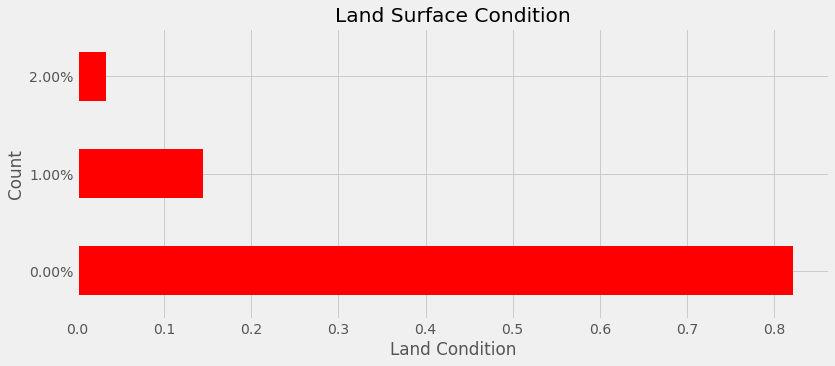

In [409]:
# Create a plot
plt.figure(figsize=(12,5))
ax = df.land_surface_condition.value_counts(normalize = True).plot(kind = "barh", color="red")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Land Surface Condition")
plt.ylabel("Count")
plt.xlabel("Land Condition")
plt.show()


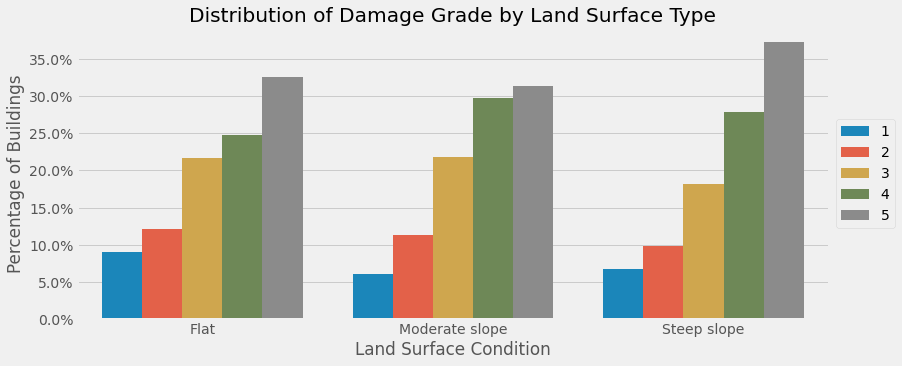

In [410]:
# Calculate counts
df_temp = df.groupby(['land_surface_condition','damage_grade']).size().reset_index(name='count')
# Set Index
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])

# Calculate Proportion of grade
df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Land Surface Type")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

In [411]:
df.foundation_type.value_counts()

Mud mortar-Stone/Brick    190705
Bamboo/Timber              19203
RC                         13891
Cement-Stone/Brick         10452
Other                       1147
Name: foundation_type, dtype: int64

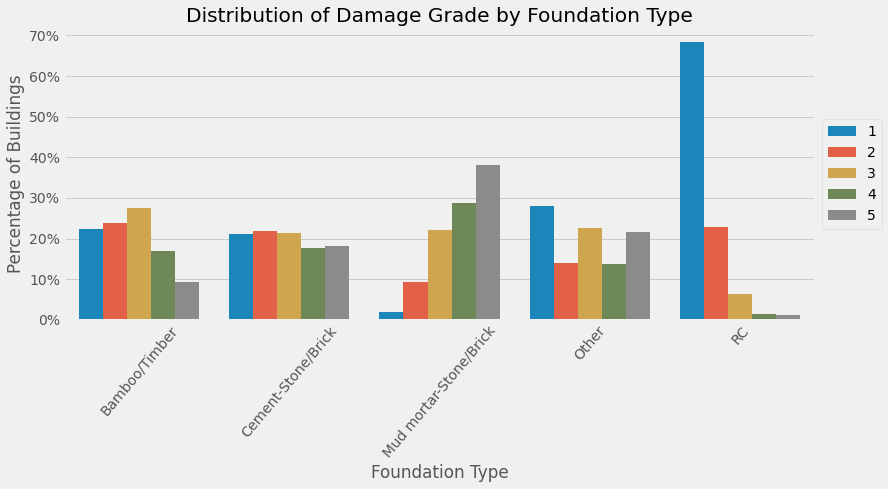

In [412]:
# Calculate counts
df_tem = df.groupby(['foundation_type','damage_grade']).size().reset_index(name='count')

# Set Index
df_tem = df_tem.set_index(['foundation_type', 'damage_grade'])

# Calculate Proportion of grade
df_tem = df_tem.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_tem, 
                 x = 'foundation_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

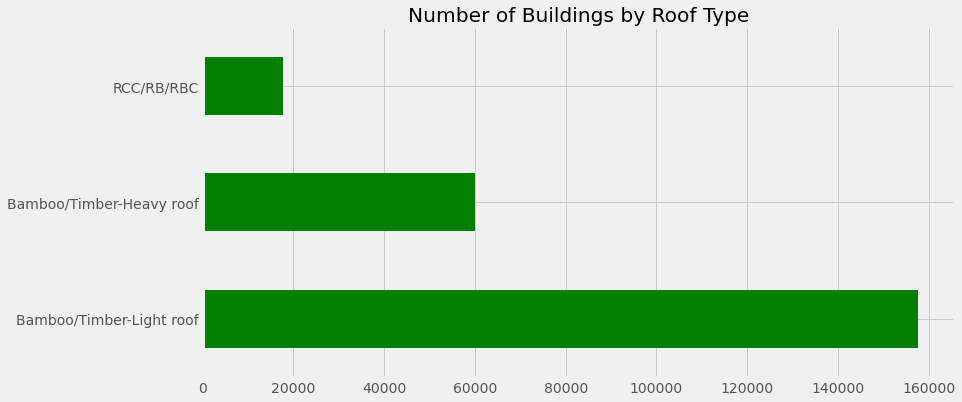

In [413]:
plt.figure(figsize = (12,6))
ax = df.roof_type.value_counts().plot(kind = "barh", color="green")
plt.title("Number of Buildings by Roof Type")
plt.show()

<AxesSubplot:xlabel='damage_grade', ylabel='age_building'>

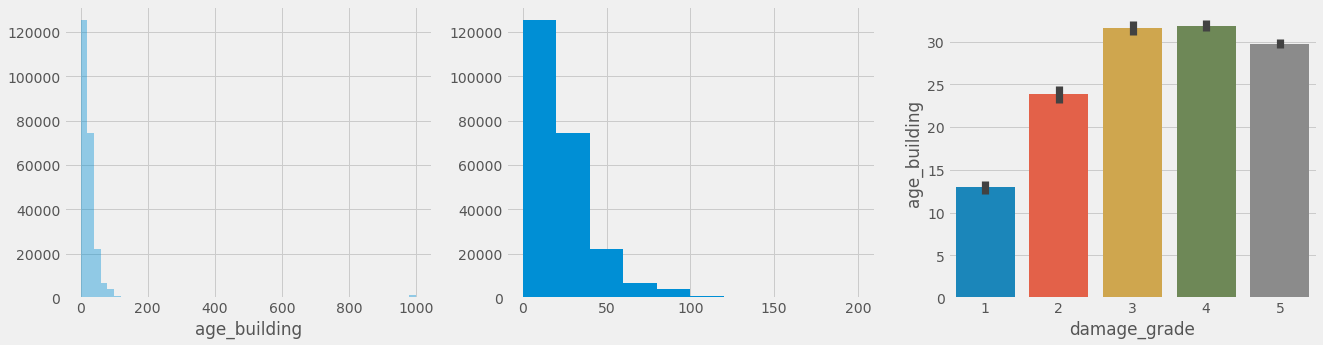

In [414]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.distplot(df['age_building'], kde = False)

plt.subplot(1,3,2)
plt.hist(df['age_building'], range=(0,200))

plt.subplot(1,3,3)
sns.barplot(df['damage_grade'],df['age_building'])

No handles with labels found to put in legend.


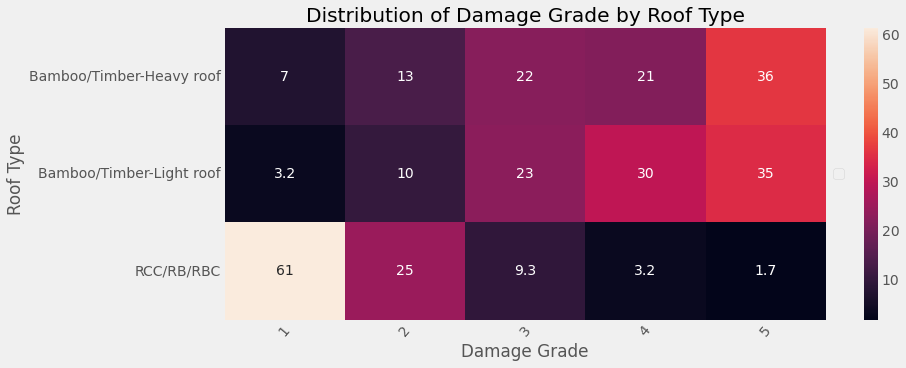

In [415]:

# Calculate counts
df_tempi = df.groupby(['roof_type','damage_grade']).size().reset_index(name='count')

# Set Index
df_tempi = df_tempi.set_index(['roof_type', 'damage_grade'])

# Calculate Proportion of grade
df_tempi = df_tempi.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_tempi = pd.pivot_table(df_tempi, values='count', index=['roof_type'], columns='damage_grade')

# Plot char
plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_tempi, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Type")
plt.show()


In [416]:
df.ground_floor_type.value_counts()

Mud            199380
RC              22286
Brick/Stone     11794
Timber           1725
Other             213
Name: ground_floor_type, dtype: int64

No handles with labels found to put in legend.


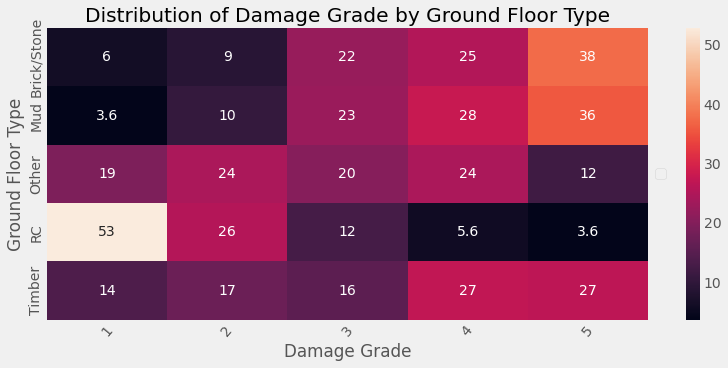

In [417]:
# Calculate counts
df_tempy = df.groupby(['ground_floor_type','damage_grade']).size().reset_index(name='count')

# Set Index
df_tempy = df_tempy.set_index(['ground_floor_type', 'damage_grade'])

# Calculate Proportion of grade
df_tempy = df_tempy.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_tempy = pd.pivot_table(df_tempy, values='count', index=['ground_floor_type'], columns='damage_grade')

# Plot char
plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_tempy, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Ground Floor Type")
plt.xlabel("Damage Grade")
plt.ylabel("Ground Floor Type")
plt.show()

In [418]:
df.other_floor_type.value_counts(normalize = True)

TImber/Bamboo-Mud    0.681964
Timber-Planck        0.139823
Not applicable       0.115851
RCC/RB/RBC           0.062362
Name: other_floor_type, dtype: float64

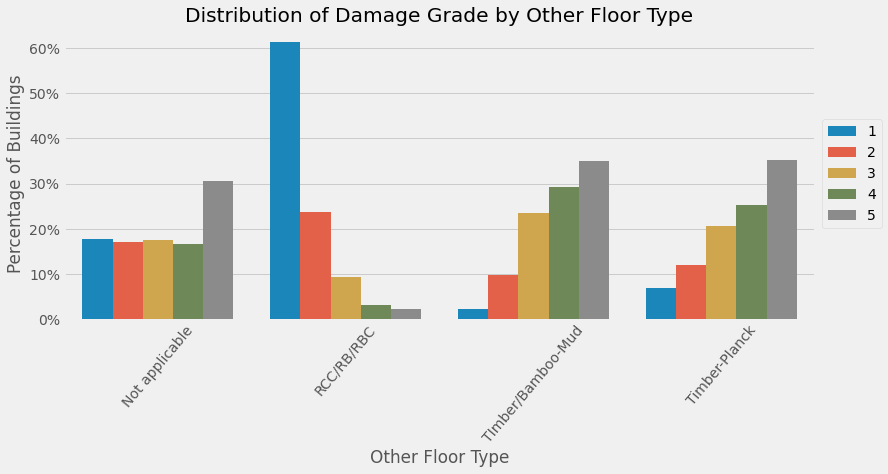

In [419]:

# Calculate counts
df_tempp = df.groupby(['other_floor_type','damage_grade']).size().reset_index(name='count')

# Set Index
df_tempp = df_tempp.set_index(['other_floor_type', 'damage_grade'])

# Calculate Proportion of grade
df_tempp = df_tempp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot char
plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_tempp, 
                 x = 'other_floor_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Other Floor Type")
plt.xlabel("Other Floor Type")
plt.ylabel("Percentage of Buildings")
plt.show()

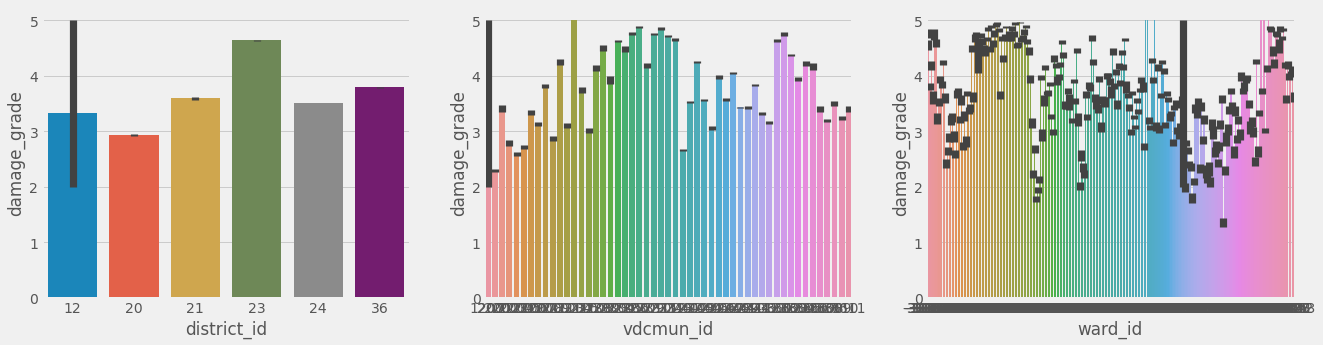

In [420]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.barplot(df['district_id'], df['damage_grade'])

plt.subplot(1,3,2)
sns.barplot(df['vdcmun_id'], df['damage_grade'])

plt.subplot(1,3,3)
sns.barplot(df['ward_id'], df['damage_grade'])

plt.show()

In [421]:
# exploring the statstical fearures of dataset.
df.describe().T.style.background_gradient(cmap='Set2',low =0.4,high=0.1,axis=0)

,count,mean,std,min,25%,50%,75%,max
building_id,235398.000000,254952472576.000000,49934729216.000000,120000004096.000000,236706004992.000000,242000003072.000000,245104001024.000000,366999994368.000000
district_id,235398.000000,25.089512,4.939783,12.000000,23.000000,24.000000,24.000000,36.000000
vdcmun_id,235398.000000,2515.568000,493.966221,1207.000000,2310.000000,2405.000000,2411.000000,3611.000000
ward_id,235398.000000,-15786.849561,17304.834040,-32715.000000,-22037.000000,-21339.000000,-20836.000000,32723.000000
count_floors_pre_eq,235398.000000,2.130919,0.668234,1.000000,2.000000,2.000000,2.000000,9.000000
count_floors_post_eq,235398.000000,1.377191,1.108281,0.000000,0.000000,2.000000,2.000000,9.000000
age_building,235398.000000,28.583595,82.094620,0.000000,10.000000,18.000000,30.000000,999.000000
plinth_area_sq_ft,235398.000000,421.563501,208.128855,70.000000,300.000000,390.000000,495.000000,5000.000000
height_ft_pre_eq,235398.000000,17.199849,6.244452,6.000000,14.000000,16.000000,20.000000,99.000000
height_ft_post_eq,235398.000000,11.379549,9.434751,0.000000,0.000000,13.000000,18.000000,96.000000


<AxesSubplot:>

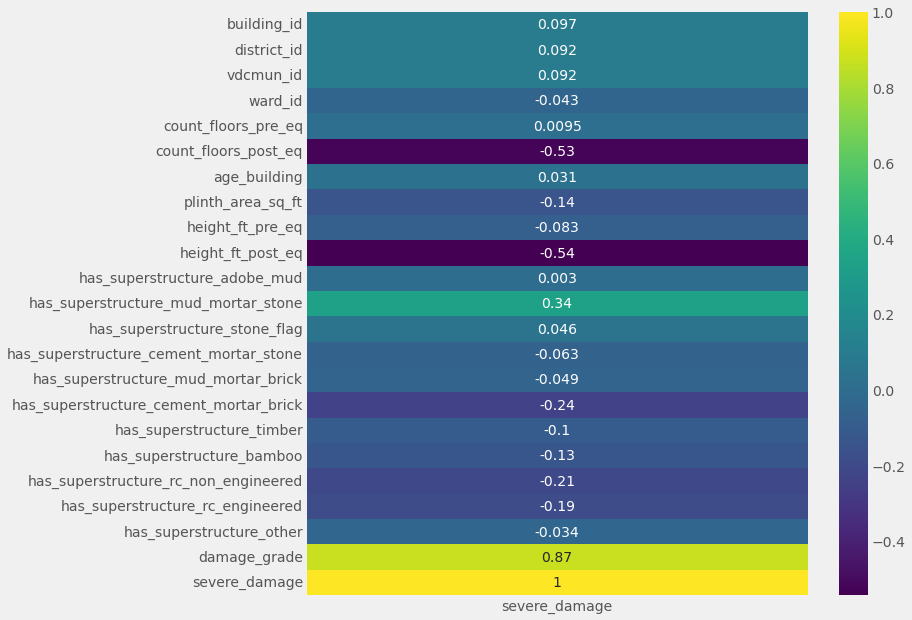

In [422]:
plt.figure(figsize=(10,10))
cor=df.corr()["severe_damage"]
cor=pd.DataFrame(cor)
sns.heatmap(cor,annot=True,cmap="viridis")

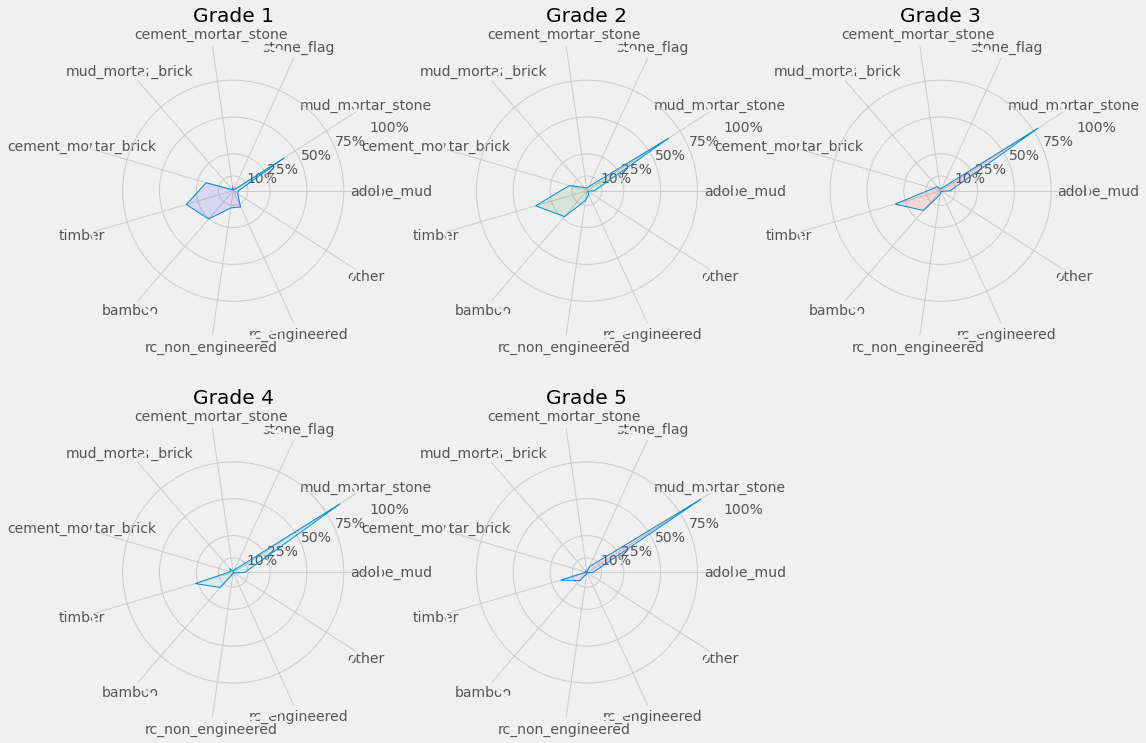

In [487]:
from math import pi # Radar chart support
# list of binary columns
v_cols = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
          'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
          'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 
          'has_superstructure_timber', 'has_superstructure_bamboo', 
          'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 
          'has_superstructure_other']

# New Names of Binary Cols
v_names = {'has_superstructure_adobe_mud':'adobe_mud', 
           'has_superstructure_mud_mortar_stone':'mud_mortar_stone',
          'has_superstructure_stone_flag':'stone_flag', 
           'has_superstructure_cement_mortar_stone':'cement_mortar_stone',
          'has_superstructure_mud_mortar_brick':'mud_mortar_brick', 
           'has_superstructure_cement_mortar_brick':'cement_mortar_brick', 
          'has_superstructure_timber':'timber', 
           'has_superstructure_bamboo':'bamboo', 
          'has_superstructure_rc_non_engineered':'rc_non_engineered', 
           'has_superstructure_rc_engineered':'rc_engineered', 
          'has_superstructure_other':'other'}

# Summarise and rename columns
df_temp = pd.read_csv("C:/Users/HP/Documents/DATASETS/Earthquake nepal/csv_building_structure22.csv").groupby('damage_grade')[v_cols].agg('mean').reset_index()
df_temp.rename(columns=v_names, inplace = True)

# Lists to use
v_grades = ['Grade ' + str(x) for x in range(1,6)]
v_colour = ['b', 'g', 'r', 'c', 'm']

# number of variables
v_categories = list(df_temp)[1:]
v_N = len(v_categories)

# Angles
v_angles = [n / float(v_N) * 2 * pi for n in range(v_N)]
v_angles += v_angles[:1]

# Initialise the plot
fig, ax = plt.subplots(2,3, figsize = (16,12), subplot_kw=dict(polar=True))

# Format axis
plt.setp(ax, # X
         xticks = v_angles[:-1], 
         xticklabels = v_categories,
         yticks = [0.10,0.25,0.50,0.75,1.0],
         yticklabels = ["10%","25%","50%","75%","100%"],
         ylim = (0,1))

# Populate plot in a loop
count, row, col = 0, 0, 0
for grade in v_grades:   
    values = df_temp.loc[count].drop('damage_grade').values.flatten().tolist()
    values += values[:1]
    ax[row, col].plot(v_angles, values, linewidth=1, linestyle='solid', label=grade)
    ax[row, col].fill(v_angles, values, v_colour[count], alpha=0.1)
    ax[row, col].set_title(grade)

    # Increment counters
    if count >= 2: # Ensure reference correct row
        row = 1
    
    if col < 2: # Ensure reference correct col
        col += 1
    else:
        col = 0
    
    count += 1 # increase count var

# Drop 6th subplot
fig.delaxes(ax[1,2])

# Clear objects
del v_cols, v_names, df_temp, v_grades, v_colour,\
    v_categories, v_N, v_angles, fig, ax, count, row, col, grade

In [423]:
#Drop columns
df.drop(columns = ["building_id", "has_superstructure_stone_flag", "has_superstructure_cement_mortar_stone", "has_superstructure_cement_mortar_brick", "has_superstructure_bamboo"], inplace=True)
df.drop(columns = ["has_superstructure_rc_engineered", "has_superstructure_other", "other_floor_type", "position"], inplace=True)
df.drop(columns = ["damage_grade", "has_superstructure_adobe_mud", "has_superstructure_mud_mortar_stone", "has_superstructure_timber", "has_superstructure_rc_non_engineered"], inplace=True)

In [424]:
df.describe()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,has_superstructure_mud_mortar_brick,severe_damage
count,235398.000000,235398.000000,235398.000000,235398.000000,235398.000000,235398.000000,235398.000000,235398.000000,235398.000000,235398.000000,235398.000000
mean,25.089512,2515.568000,-15786.849561,2.130919,1.377191,28.583595,421.563501,17.199849,11.379549,0.041440,0.581058
std,4.939783,493.966221,17304.834040,0.668234,1.108281,82.094620,208.128855,6.244452,9.434751,0.199307,0.493387
min,12.000000,1207.000000,-32715.000000,1.000000,0.000000,0.000000,70.000000,6.000000,0.000000,0.000000,0.000000
25%,23.000000,2310.000000,-22037.000000,2.000000,0.000000,10.000000,300.000000,14.000000,0.000000,0.000000,0.000000
50%,24.000000,2405.000000,-21339.000000,2.000000,2.000000,18.000000,390.000000,16.000000,13.000000,0.000000,1.000000
75%,24.000000,2411.000000,-20836.000000,2.000000,2.000000,30.000000,495.000000,20.000000,18.000000,0.000000,1.000000
max,36.000000,3611.000000,32723.000000,9.000000,9.000000,999.000000,5000.000000,99.000000,96.000000,1.000000,1.000000


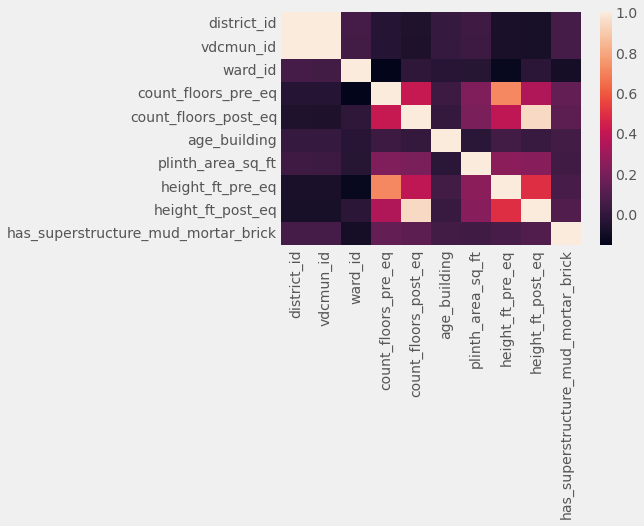

In [425]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()

# Plot heatmap of `correlation`
sns.heatmap(correlation);

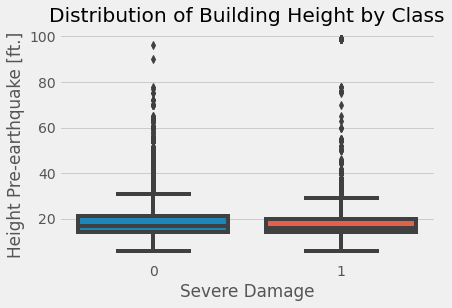

In [426]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)

# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-earthquake [ft.]")
plt.title("Distribution of Building Height by Class");

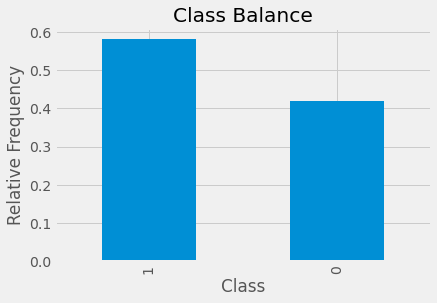

In [427]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

In [428]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.581058462688723 0.4189415373112771


In [429]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.024620
Bamboo/Timber,0.263969
Other,0.353095
Cement-Stone/Brick,0.359548
Mud mortar-Stone/Brick,0.667030


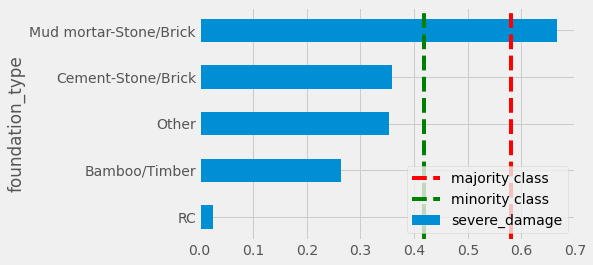

In [430]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label="minority class"
)
plt.legend(loc="lower right");

In [431]:
df.select_dtypes("object").nunique()

land_surface_condition          3
foundation_type                 5
roof_type                       3
ground_floor_type               5
plan_configuration             10
condition_post_eq               8
technical_solution_proposed     4
dtype: int64

In [434]:
#Split
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (235398, 17)
y shape: (235398,)


In [436]:
#Dividing my data (X and y) into training and test sets using a randomized train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (188318, 17)
y_train shape: (188318,)
X_test shape: (47080, 17)
y_test shape: (47080,)


In [437]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.58


In [438]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000000)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'plan_configuration',
                                     'condition_post_eq',
                                     'technical_solution_proposed'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000000))])

In [439]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.91
Test Accuracy: 0.91


In [440]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.95172395 0.04827605]
 [0.25364004 0.74635996]
 [0.69575699 0.30424301]
 [0.22426245 0.77573755]
 [0.97992351 0.02007649]]


In [441]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [442]:
#Creating a series using pandas
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

technical_solution_proposed_Major repair       0.341127
technical_solution_proposed_Minor repair       0.373711
condition_post_eq_Damaged-Repaired and used    0.548300
ground_floor_type_RC                           0.656032
condition_post_eq_Not damaged                  0.662953
dtype: float64

In [443]:
odds_ratios = feat_imp
odds_ratios.head()

technical_solution_proposed_Major repair       0.341127
technical_solution_proposed_Minor repair       0.373711
condition_post_eq_Damaged-Repaired and used    0.548300
ground_floor_type_RC                           0.656032
condition_post_eq_Not damaged                  0.662953
dtype: float64

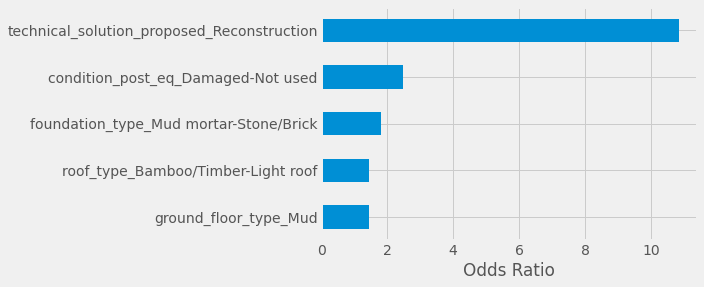

In [444]:
# Horizontal bar chart, five largest coefficients
feat_imp.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

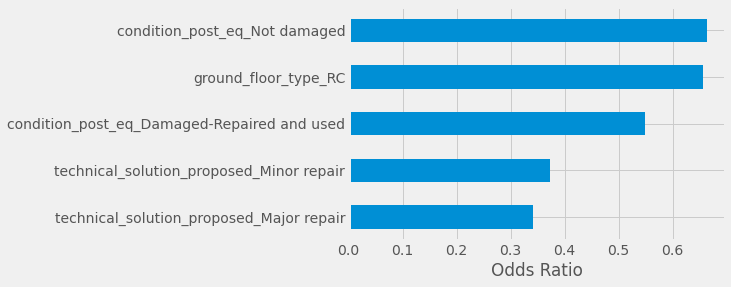

In [445]:
# Horizontal bar chart, five smallest coefficients
feat_imp.head().plot(kind="barh")
plt.xlabel("Odds Ratio");

In [446]:
df.drop(columns= ["count_floors_pre_eq"], inplace=True)

In [447]:
#Decision tree


In [448]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [449]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [450]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [451]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.58


In [452]:
# Build Model
model_ = make_pipeline(
    OrdinalEncoder(), DecisionTreeClassifier(max_depth=20, random_state=42)
)
# Fit model to training data
model_.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'plan_configuration',
                                      'condition_post_eq',
                                      'technical_solution_proposed'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Steep slope       2
Moderate slope    3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          '...
Damaged-Repaired and used                  4
Damaged-Not used                           5
Damaged-Rubble unclear                     6
Damaged-Rubble Clear-New building built    7
Covered by landslide                

In [453]:
acc_train = accuracy_score(y_train, model_.predict(X_train))
acc_val = model_.score(X_val, y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.98
Validation Accuracy: 0.94


In [454]:
# how deep my tree grew during training.
tree_depth = model_.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

Tree Depth: 20


In [461]:
depth_hyperparams = range(1, 21, 2)

In [462]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.9215155256415363, 0.9215155256415363, 0.9224381695806284]
Validation Accuracy Scores: [0.9204014443500425, 0.9204014443500425, 0.9212776125743416]


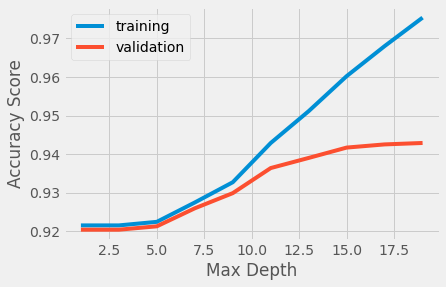

In [463]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [465]:
test_acc = model_.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

Test Accuracy: 0.94


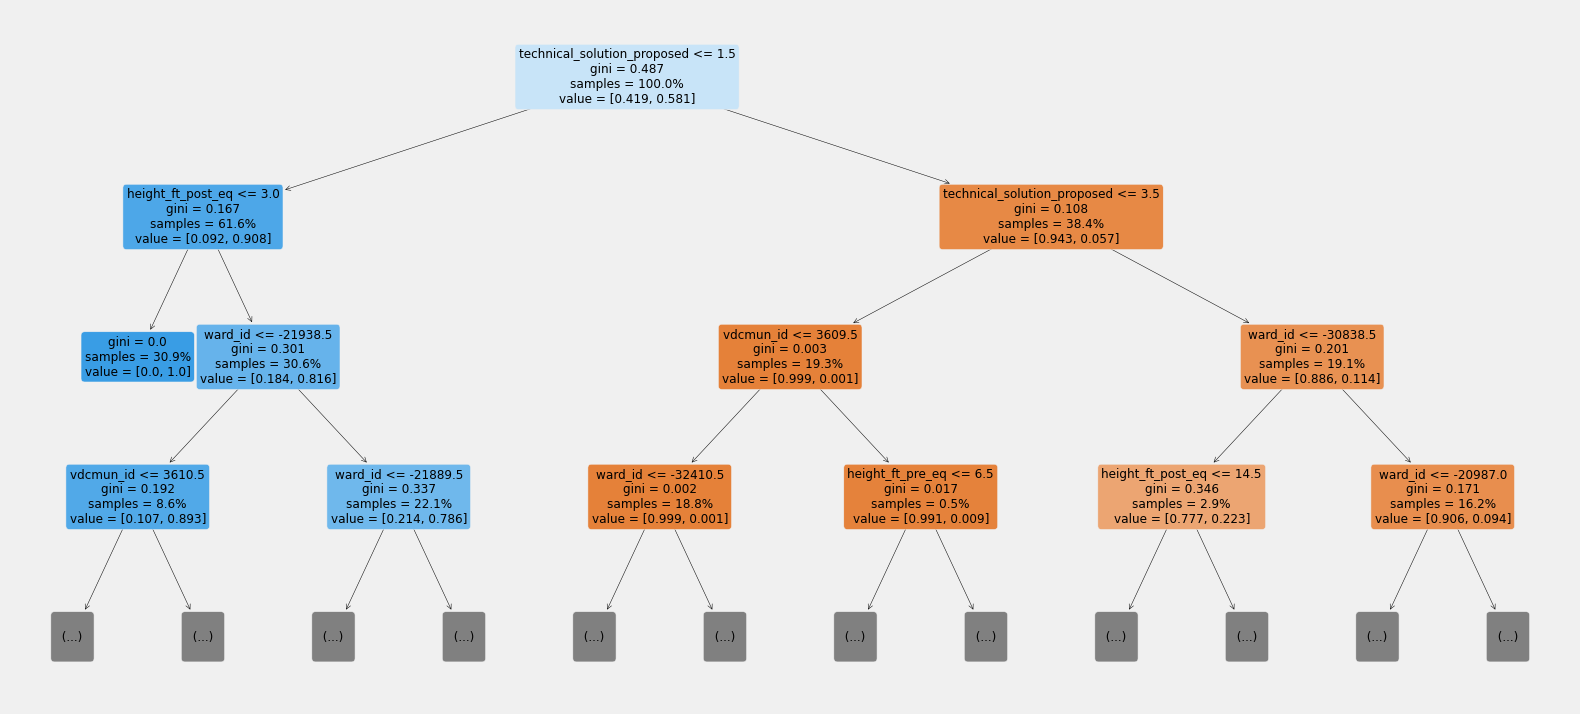

In [466]:
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree= model_.named_steps["decisiontreeclassifier"],
    feature_names= X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [467]:
features = X_train.columns
importances = model_.named_steps["decisiontreeclassifier"].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['district_id', 'vdcmun_id', 'ward_id'], dtype='object')
Importances: [0.00042383 0.01138142 0.07202995]


In [468]:
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

district_id                            1.000424
plan_configuration                     1.001200
has_superstructure_mud_mortar_brick    1.001210
foundation_type                        1.002517
roof_type                              1.003546
dtype: float64

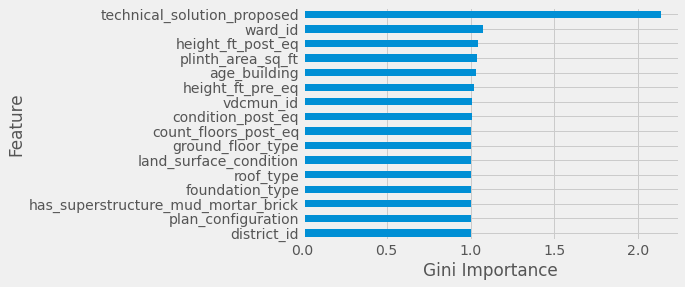

In [469]:
# Create horizontal bar chart
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature");

In [470]:
df.head()

,district_id,vdcmun_id,ward_id,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,plan_configuration,has_superstructure_mud_mortar_brick,condition_post_eq,technical_solution_proposed,severe_damage
0,12,1207,-10369,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Rectangular,0,Damaged-Used in risk,Major repair,0
1,12,1207,-10369,1,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Rectangular,0,Damaged-Repaired and used,Reconstruction,1
2,12,1207,-10369,1,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Rectangular,0,Damaged-Repaired and used,Minor repair,0
71035,36,3606,-32612,0,50,464,13,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Rectangular,0,Damaged-Rubble Clear-New building built,Reconstruction,1
71036,36,3606,-32612,1,25,494,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Rectangular,0,Damaged-Repaired and used,Reconstruction,1


In [471]:
top_10 = df["vdcmun_id"].value_counts().head(10).index
df["vdcmun_id"].apply(lambda c: c if c in top_10 else "Other").value_counts()

Other    122373
2408      17177
2401      13993
2409      13046
2411      12822
3608      10460
2412       9965
2405       9268
2402       8954
2410       8858
2404       8482
Name: vdcmun_id, dtype: int64

In [472]:
df["vdcmun_id"].apply(lambda c: c if c in top_10 else "Other")

0         Other
1         Other
2         Other
71035     Other
71036     Other
          ...  
387960    Other
387961    Other
387962    Other
387963    Other
387964    Other
Name: vdcmun_id, Length: 235398, dtype: object

In [473]:
df["vdcmun_id"].nunique()

51

In [474]:
#Split
target = "severe_damage"
X = df.drop(columns=[target, "vdcmun_id"])
y = df[target]

In [475]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [476]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.58


In [477]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=3000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'plan_configuration',
                                     'condition_post_eq',
                                     'technical_solution_proposed'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [478]:
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
acc_test = accuracy_score(y_test, model_lr.predict(X_test))

print("LR Training Accuracy:", acc_train)
print("LR Validation Accuracy:", acc_test)

LR Training Accuracy: 0.920687347996474
LR Validation Accuracy: 0.9204545454545454


In [479]:
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

technical_solution_proposed_Minor repair       0.218224
technical_solution_proposed_Major repair       0.334281
condition_post_eq_Damaged-Repaired and used    0.498207
condition_post_eq_Not damaged                  0.572790
technical_solution_proposed_No need            0.595470
dtype: float64

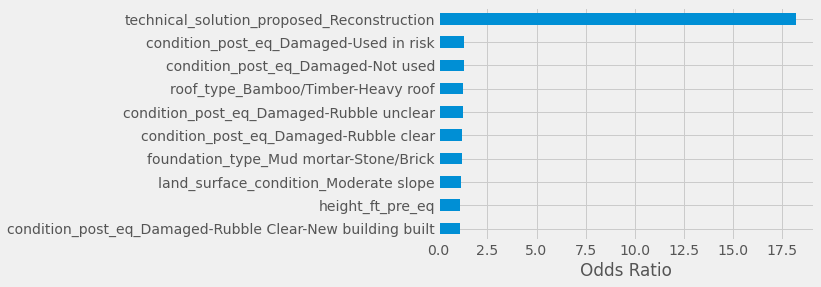

In [480]:
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

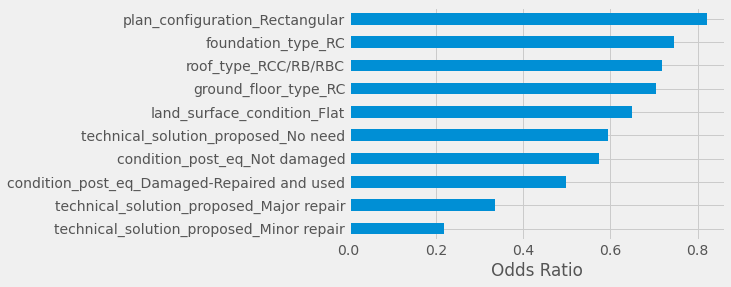

In [481]:
feat_imp.head(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

In [482]:
damage_by_vdcmun = (
    df.groupby("vdcmun_id") ["severe_damage"].mean().sort_values(ascending=False)
).to_frame()
damage_by_vdcmun

,severe_damage
vdcmun_id,
2104,1.000000
2307,0.980418
2311,0.965083
3602,0.951195
2310,0.949119
2306,0.948521
2312,0.937596
2313,0.936680
2304,0.928106


In [484]:
def ecdf(series):
    ''' This function calculates the ECDF for a series of real numbers'''
    
    # Number of data points
    n = len(series)
    
    # Sort output
    x = np.sort(series)
    
    # Sequence proportion
    y = np.arange(1, n+ 1) / n * 100
    
    # Return dataframe
    return pd.DataFrame({'x':x, 'y':y})

In [485]:
df["age_building"].astype(pd.StringDtype())

0          9
1         15
2         20
71035     50
71036     25
          ..
387960    25
387961     4
387962    12
387963     6
387964     3
Name: age_building, Length: 235398, dtype: string

In [437]:
#THANK YOU!!!